# Neural Networks Learn Atari Breakout

This notebook contains the source code from the YouTube video [Neural Network Learns To Play Atari Breakout](url_here) and walks you through how to define a neural network in Tensorflow 2.0 and Pytorch and train it to learn to play Atari Breakout.

## 1. Install Dependencies

Import the libraries that are needed for loading the Breakout Unity game ([mlagents](https://github.com/Unity-Technologies/ml-agents)), defining the Tensorflow 2.0 neural network ([tensorflow](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf)) and the Pytorch version ([torch](https://pytorch.org/docs/stable/index.html)). Note that the ML-Agents library requires [Python 3.6](https://www.python.org/downloads/release/python-368/).

In [1]:
!pip3 install -q mlagents==0.7
!pip3 install -q tensorflow==2.0.0-alpha0
!pip3 install -q torch==1.0.1.post2

## 2. Load the Unity Environment

The next step is to load the Breakout environment as a `UnityEnvironment` object which launches and begins communication with the Unity game executable when instantiated. The `unity_env` variable is the handle for sending agent actions to the game and receiving resulting next/terminal states and rewards at each time step.

In [2]:
import os
import platform
import numpy as np
from mlagents.envs import UnityEnvironment

unity_files = {"Linux": "./env/linux/Breakout", "Darwin": "./env/mac/Breakout", "Windows": "./env/windows/Breakout"}
unity_file = unity_files[platform.system()]
unity_env = UnityEnvironment(file_name=unity_file)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of Training Brains : 1
        Reset Parameters :
		episode -> 0.0
Unity brain name: BreakoutLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 54
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3]
        Vector Action descriptions: 
Unity brain name: BreakoutPlayer
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 54
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3]
        Vector Action descriptions: 


In [7]:
import os
import platform
import numpy as np
from mlagents.envs import UnityEnvironment

unity_files = {"Linux": "./env/linux/Breakout", "Darwin": "./env/mac/Breakout", "Windows": "./env/windows/Breakout"}
unity_file = unity_files[platform.system()]
unity_env = UnityEnvironment(file_name=unity_file)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of Training Brains : 1
        Reset Parameters :
		episode -> 0.0
Unity brain name: BreakoutLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 54
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3]
        Vector Action descriptions: 
Unity brain name: BreakoutPlayer
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 54
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3]
        Vector Action descriptions: 


### 2.1 Create OpenAI Gym Wrapper for Unity Environment

As most people are more familiar with the gym API of [OpenAI Gym](https://gym.openai.com/docs/) for communicating with an environment, we will create a wrapper class `GymEnvironment` that mimics the OpenAI Gym environment functions for resetting and stepping through an environment. You can also do any preprocessing of states returned from the environment or adjust the reward signal.

- For more info, check out this tutorial video for [Getting Started with OpenAI Gym](https://www.youtube.com/watch?v=8MC3y7ASoPs)

In [8]:
class GymEnvironment():
    def __init__(self, unity_env):
        self.env = unity_env
        self.default_brain = unity_env.brain_names[0]
        self.observation_space_size = unity_env.brains[self.default_brain].vector_observation_space_size
        self.action_space_size = int(unity_env.brains[self.default_brain].vector_action_space_size[0])
        
    def reset(self, train_mode=True):
        self.env_info = self.env.reset(train_mode=train_mode)[self.default_brain]
        return self.env_info.vector_observations[0]
    
    def step(self, action):
        self.env_info = self.env.step(action)[self.default_brain]
        next_state = self.env_info.vector_observations[0]
        reward = self.env_info.rewards[0]
        done = self.env_info.local_done[0]
        return next_state, reward, done, self.env_info
    
    def close(self):
        self.env.close()

### 2.2 Understand the Breakout Environment

We can reset the environment to be provided with an initial set of states for the agent in the environment. The `action_size` variable holds the number of actions that the agent can choose from. _states_ refer to a vector of variables corresponding to relevant aspects of the environment that the agent 'sees'.


![AtariBreakout](./AtariBreakout.png)


In the breakout environment, the agent is controlling a paddle at the bottom of the screen and can between 3 actions: to move it left, right or no movement. Its goal is to hit the ball to destroy all the floating bricks and prevent the ball from falling to the bottom. It will get a reward of +1 whenever the ball hits a brick and -1 for each brick remaining if the ball falls to the bottom.

The state consists of 54 numbers where the first two are the ball's `x` and `y` position, the next two are the ball's `x` and `y` velocity, the next two are the paddle's `x` position and `x` velocity and the remaining 48 represent each brick's status of destroyed (0.) or remaining (1.)

In [9]:
env = GymEnvironment(unity_env)
action_size = env.action_space_size
state_size = env.observation_space_size
state = env.reset()

print('Number of actions:', action_size)
print('States have length:', state_size)
print('States look like:', state)

Number of actions: 3
States have length: 54
States look like: [ 0.          0.         -2.77063155  5.3219924   0.          0.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.        ]


## 3. Define the Reinforcement Learning Components

The next step is to define the components that make up the reinforcement learning algorithm. This requires defining:

- **3.1** The neural network architecture to approximate the Q function.
- **3.2** The experience replay buffer for storing and sampling batches of experience tuples.
- **3.3** The Q-Learning agent that samples from the replay buffer and trains the neural network.

#### 3.1.0 Neural Network Hyperparameters

These are the settings for the neural network that we need to tweak to suit our particular task of playing Breakout. 

In [10]:
HIDDEN_SIZE = 800             # Specifies the number of nodes in each layer of the network
LEARNING_RATE = 0.00002       # Sets how much we want to update the network weights at each training step
REGULARIZER_LAMBDA = 1e-6     # Penalty multiplier to apply for the size of the network weights
TARGET_UPDATE_RATE = 0.0004   # How frequently we want to copy the local network to the target network (for double DQNs)

####  3.1.1 Tensorflow QNetwork

Below is the implementation of a Deep Q Network using TensorFlow 2.0 as the backend model. The `TFModel` class defines the actual neural network architecture for approximating the Q-function and the `TFQNetwork` incorporates the neural network to define a function for retrieving the output q-values from an input state (`get_q_state`) and also a function for training the neural network (`optimize`).

Resources:
- A tutorial video on [Getting Started with Tensorflow 2.0](https://www.youtube.com/watch?v=fQCKxzHvYnw)
- A tutorial video on [Basic Deep Q Network (DQN) in Tensorflow](https://www.youtube.com/watch?v=dpBKz1wxE_c)
- A tutorial video on [Upgrading a DQN to a Double DQN](https://www.youtube.com/watch?v=ILDLT97FsNM)

In [11]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

class TFModel(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = tf.keras.layers.Dense(HIDDEN_SIZE, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_normal())
        self.hidden2 = tf.keras.layers.Dense(HIDDEN_SIZE, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_normal(), kernel_regularizer=tf.keras.regularizers.l2(l=REGULARIZER_LAMBDA))
        self.q_state = tf.keras.layers.Dense(action_size, activation=None, kernel_initializer=tf.initializers.glorot_normal())
        
    def call(self, state):
        hidden1 = self.hidden1(state)
        hidden2 = self.hidden2(hidden1) + hidden1
        q_state = self.q_state(hidden2)
        return q_state
    
class TFQNetwork():
    def __init__(self, state_size, action_size, load=False):
        self.model_local = TFModel(state_size, action_size)
        self.model_target = TFModel(state_size, action_size)
        self.optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
        self.action_size = action_size
        if load: self.load_model()
        
    def get_q_state(self, state, use_target=False):
        model = self.model_local if not use_target else self.model_target
        return model(np.array(state)).numpy()
    
    def get_loss(self, states, actions, q_targets):
        actions_one_hot = tf.one_hot(actions, depth=self.action_size)
        q_states = tf.cast(self.model_local(states), tf.float32)
        q_states_actions = tf.reduce_sum(tf.multiply(q_states, actions_one_hot), axis=1)
        loss = tf.reduce_sum(tf.square(q_states_actions - q_targets))
        return loss
    
    def optimize(self, states, actions, q_targets):
        loss = lambda: self.get_loss(states, actions, q_targets)
        self.optimizer.minimize(loss=loss, var_list=self.model_local.trainable_weights)
        self.soft_copy(self.model_local, self.model_target)
        
    def soft_copy(self, local, target, tau=TARGET_UPDATE_RATE):
        new_target_vars = [t + tau*(l-t) for l,t in zip(local.get_weights(), target.get_weights())]
        self.model_target.set_weights(new_target_vars)
        
    def save_model(self, filepath="./saved_models/tensorflow2/model.tf"):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        self.model_local.save_weights(filepath)
        
    def load_model(self, filepath="./saved_models/tensorflow2/model.tf"):
        if os.path.exists(filepath + ".index"):
            self.model_local.load_weights(filepath)
            self.model_target.load_weights(filepath)

ImportError: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/anaconda3/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/anaconda3/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: dlopen(/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so, 6): Symbol not found: _clock_gettime
  Referenced from: /anaconda3/lib/python3.6/site-packages/tensorflow/python/../libtensorflow_framework.so (which was built for Mac OS X 10.13)
  Expected in: /usr/lib/libSystem.B.dylib
 in /anaconda3/lib/python3.6/site-packages/tensorflow/python/../libtensorflow_framework.so


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

#### 3.1.2 PyTorch QNetwork

Below is the implementation of a QNetwork using PyTorch as the backend model. The `PTModel` class defines the actual neural network architecture for approximating the Q-function and the `PTQNetwork` is the equivalent of the `TFQNetwork` adapted for PyTorch.

In [ ]:
import torch
print("PyTorch:", torch.__version__)

class PTModel(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = torch.nn.Linear(state_size, HIDDEN_SIZE)
        self.hidden2 = torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.q_state = torch.nn.Linear(HIDDEN_SIZE, action_size)
        torch.nn.init.xavier_normal_(self.hidden1.weight)
        torch.nn.init.xavier_normal_(self.hidden2.weight)
        torch.nn.init.xavier_normal_(self.q_state.weight)

    def forward(self, state):
        hidden1 = torch.nn.functional.relu(self.hidden1(state))
        hidden2 = torch.nn.functional.relu(self.hidden2(hidden1)) + hidden1
        q_state = self.q_state(hidden2)
        return q_state

class PTQNetwork():
    def __init__(self, state_size, action_size, load=False):
        self.model_local = PTModel(state_size, action_size)
        self.model_target = PTModel(state_size, action_size)
        self.optimizer = torch.optim.Adam(self.model_local.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZER_LAMBDA)
        if load: self.load_model()

    def get_q_state(self, state, use_target=False):
        model = self.model_local if not use_target else self.model_target
        state = torch.from_numpy(np.array(state)).float()
        return model(state).detach().numpy()
    
    def get_loss(self, states, actions, q_targets):
        states = torch.from_numpy(np.vstack(states)).float()
        actions = torch.from_numpy(np.vstack(actions)).long()
        q_targets = torch.from_numpy(np.vstack(q_targets)).float()
        q_states_actions = self.model_local(states).gather(1, actions)
        loss = (q_states_actions - q_targets)**2
        return loss.mean()
    
    def optimize(self, states, actions, q_targets):
        loss = self.get_loss(states, actions, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_copy(self.model_local, self.model_target)
        
    def soft_copy(self, local, target, tau=TARGET_UPDATE_RATE):
        for l,t in zip(local.parameters(), target.parameters()):
            t.data.copy_(t.data + tau*(l.data - t.data))
        
    def save_model(self, filepath="./saved_models/pytorch/checkpoint.pth"):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save(self.model_local.state_dict(), filepath)
        
    def load_model(self, filepath="./saved_models/pytorch/checkpoint.pth"):
        if os.path.exists(filepath):
            self.model_local.load_state_dict(torch.load(filepath))
            self.model_target.load_state_dict(torch.load(filepath))

### 3.2 Experience Replay

Below is the implementation of a Replay Buffer using the `deque` collection as the rolling buffer of experience tuples. This can be sampled by specifying the sample size and then returns each individual experience type as separate lists.

- Check out this tutorial video on [How Experience Replay Works](https://www.youtube.com/watch?v=lQB08wcuCeM)

In [ ]:
from collections import deque
import random

class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

### 3.3 Q-Learning Algorithm

This step implements the final AI agent that uses Deep Q Networks to learn the Bellman equation for selecting actions to take in a given state from the environment. It instantiates a QNetwork of the specified implementation (`TFQNetwork` or `PTQNetwork`) as well as the `ReplayBuffer` for experience replay.

- Check out this tutorial video for [Q-Learning with the Bellman Equation](https://www.youtube.com/watch?v=wN3rxIKmMgE)

#### 3.3.0 Q-Learning Hyperparameters

Here we define the settings for the training of the agent.

In [12]:
MAX_BUFFER_SIZE = 1000000   # Sets the maximum length of the replay buffer
REPLAY_BATCH_SIZE = 32      # How many experience tuples to sample from the buffer for each train step
DISCOUNT_RATE = 0.99        # The constant gamma for discounting future rewards in the Bellman Equation
EPS_MAX = 1.0               # The starting proportion of random to greedy actions to take
EPS_MIN = 0.1               # The lower limit proportion of random to greedy actions to take
EPS_DECAY = 0.998           # The rate at which eps decays from EPS_MAX to EPS_MIN

#### 3.3.1 Q-Learning Agent

The `get_action` function infers an action from the QNetwork from a given state using an epsilon-greedy policy for choosing a random action more often at the start of training for exploration, and then selecting the greedy action more often later in training as the network's approximation of the Q-Function (Bellman Equation) improves.

The `train` function calculates the target Q-value (`q_target`) for the `reward` from the `action` taken in the given `state` and then trains the QNetwork toward that value for the input state and action.

In [13]:
class DQNAgent():
    def __init__(self, state_size, action_size, network=TFQNetwork, eps=EPS_MAX, load=False):
        self.state_size = state_size
        self.action_size = action_size
        self.q_network = network(state_size, action_size, load)
        self.replay_buffer = ReplayBuffer(MAX_BUFFER_SIZE)
        self.gamma = DISCOUNT_RATE
        self.eps = eps

    def get_action(self, state, eps=None):
        eps = self.eps if eps == None else eps
        action_greedy = np.argmax(self.q_network.get_q_state([state]))
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < eps else action_greedy
        return action
        
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(REPLAY_BATCH_SIZE)
        
        next_actions = np.argmax(self.q_network.get_q_state(next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(next_states, use_target=True)
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions
        self.q_network.optimize(states, actions, q_targets)

        if done: self.eps = max(self.eps * EPS_DECAY, EPS_MIN)

NameError: name 'TFQNetwork' is not defined

## 4. Train the Agent

Below is the training loop for training the agent through a number of episodes of interacting with the environment. It keeps track of the total reward from each episode and also stores the last 100 episode rewards for calculating the average reward.

In [3]:
networks = [TFQNetwork, PTQNetwork]
agent = DQNAgent(state_size, action_size, network=networks[0], eps=1.0, load=False)

scores = []
scores_buffer = deque(maxlen=100)
avg_scores = []
num_episodes = 2000
for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, next_state, reward, done)
        total_reward += reward  
        state = next_state 

    scores.append(total_reward)
    scores_buffer.append(total_reward)
    avg_scores.append(np.mean(scores_buffer))
    if avg_scores[-1] >= np.max(avg_scores): agent.q_network.save_model()
    print("Episode: {}, Score: {}, Avg reward: {:.2f}".format(ep, scores[-1], avg_scores[-1])) 

Episode: 0, Score: -44.0, Avg reward: -44.00
Episode: 1, Score: -46.0, Avg reward: -45.00
Episode: 2, Score: -44.0, Avg reward: -44.67
Episode: 3, Score: -48.0, Avg reward: -45.50
Episode: 4, Score: -48.0, Avg reward: -46.00
Episode: 5, Score: -48.0, Avg reward: -46.33
Episode: 6, Score: -32.0, Avg reward: -44.29
Episode: 7, Score: -42.0, Avg reward: -44.00
Episode: 8, Score: -48.0, Avg reward: -44.44
Episode: 9, Score: -44.0, Avg reward: -44.40
Episode: 10, Score: -48.0, Avg reward: -44.73
Episode: 11, Score: -44.0, Avg reward: -44.67
Episode: 12, Score: -36.0, Avg reward: -44.00
Episode: 13, Score: -48.0, Avg reward: -44.29
Episode: 14, Score: -44.0, Avg reward: -44.27
Episode: 15, Score: -48.0, Avg reward: -44.50
Episode: 16, Score: -48.0, Avg reward: -44.71
Episode: 17, Score: -46.0, Avg reward: -44.78
Episode: 18, Score: -38.0, Avg reward: -44.42
Episode: 19, Score: -42.0, Avg reward: -44.30
Episode: 20, Score: -48.0, Avg reward: -44.48
Episode: 21, Score: -42.0, Avg reward: -44.3

Episode: 1356, Score: 14.0, Avg reward: -0.80
Episode: 1357, Score: 8.0, Avg reward: -0.56
Episode: 1358, Score: -14.0, Avg reward: -0.74
Episode: 1359, Score: -8.0, Avg reward: -1.06
Episode: 1360, Score: -4.0, Avg reward: -1.18
Episode: 1361, Score: 12.0, Avg reward: -1.18
Episode: 1362, Score: 22.0, Avg reward: -0.92
Episode: 1363, Score: 6.0, Avg reward: -0.66
Episode: 1364, Score: -4.0, Avg reward: -0.84
Episode: 1365, Score: 24.0, Avg reward: -0.34
Episode: 1366, Score: 2.0, Avg reward: 0.00
Episode: 1367, Score: -36.0, Avg reward: 0.02
Episode: 1368, Score: 6.0, Avg reward: -0.04
Episode: 1369, Score: 6.0, Avg reward: 0.20
Episode: 1370, Score: 6.0, Avg reward: 0.22
Episode: 1371, Score: -20.0, Avg reward: 0.36
Episode: 1372, Score: 16.0, Avg reward: 0.56
Episode: 1373, Score: -16.0, Avg reward: 0.74
Episode: 1374, Score: 28.0, Avg reward: 0.92
Episode: 1375, Score: -8.0, Avg reward: 0.80
Episode: 1376, Score: 0.0, Avg reward: 0.50
Episode: 1377, Score: 2.0, Avg reward: 0.42
Epi

### 4.1 Plotting the training rewards

The plot below shows the total reward from each episode (blue) and the average reward over the last 100 episodes (orange). We can see that the agent was able to reach the average reward of 20 after about 1750 episodes.

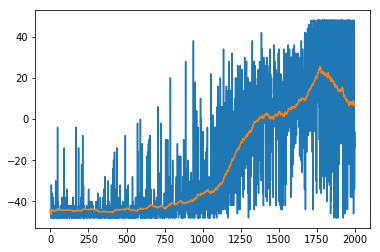

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(len(scores))
plt.plot(x,scores, x,avg_scores)

## 5. Test the Agent

The cell below creates a test agent loading the trained weights for a test run of the environment with the trained model.

In [14]:
test_agent = DQNAgent(state_size, action_size, load=True)
state = env.reset(train_mode=False)
total_reward = 0
done = False
while not done:
    action = test_agent.get_action(state, eps=0.0)
    next_state, reward, done, info = env.step(action)
    total_reward += reward  
    state = next_state 
print("Score: {}".format(total_reward))

Episode: 0, Score: 18


## 6. Close the environment when finished
When we are finished using an environment, we can close it with the function below.

In [14]:
env.close()